In [1]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from pathlib import Path
import os

# Set up paths
PYTHONPATH = "/global/homes/b/bpb/repos/envnet"
os.environ['PYTHONPATH'] = PYTHONPATH

# Import ENVnet
import sys
sys.path.insert(0, PYTHONPATH)

from envnet.deconvolution.validation import DeconvolutionValidator
from envnet.config import DeconvolutionConfig, BuildConfig
from envnet.build.reference import load_p2d2_reference_data # Import the correct function

# --- THIS IS THE CORRECTED WORKFLOW ---

# 1. Load the MDM neutral loss data required by the p2d2 loader
print("Loading MDM neutral loss data...")
mdm_path = Path(PYTHONPATH) / "envnet" / "data" / "mdm_neutral_losses.csv"
mdm_df = pd.read_csv(mdm_path)

# 2. Load the P2D2 reference library using the correct function
print("Loading P2D2 reference spectral library...")
# This function returns two dataframes; we need the first one for the original spectra.
ref_df, _ = load_p2d2_reference_data(deltas=mdm_df)

# 3. Manually populate the BuildConfig with the loaded P2D2 spectra
build_config = BuildConfig(file_metadata_path='/global/homes/b/bpb/repos/envnet/scripts/build_files.csv')
# The validator expects lists/arrays of spectra and precursor m/z values.
build_config.ref_spec = ref_df['spectrum'].tolist()
build_config.ref_pmz = ref_df['precursor_mz'].tolist()
# The validator also needs a mapping from the original p2d2 index to the new list index
ref_df = ref_df.reset_index().rename(columns={'index': 'ref_spec_index'})
build_config.ref_nodes = ref_df

# 4. Set the path for the validation ground-truth file (I think this is never used)
validation_data_path = Path(PYTHONPATH) / "envnet" / "data" / "library_matches_deconvoluted.csv"
build_config.file_metadata_path = str(validation_data_path)
build_config.validation_data_source = 'local_csv'

# 5. Configure deconvolution parameters
deconv_config = DeconvolutionConfig(
    z_score_threshold=2,
    num_points=3,
    isolation_tolerance=0.75
)

# 6. Run validation using the fully populated config objects
print("Running deconvolution validation...")
validator = DeconvolutionValidator(deconv_config=deconv_config, build_config=build_config)
results_df, summary = validator.run_comprehensive_validation(max_groups=50)

# --- END OF CORRECTION ---

print("\n--- Validation Summary ---")
print(f"Fragment Precision: {summary['overall_fragment_precision']:.4f}")
print(f"Fragment Recall: {summary['overall_fragment_recall']:.4f}")

Loading MDM neutral loss data...
Loading P2D2 reference spectral library...
Loading file list from CSV: /global/homes/b/bpb/repos/envnet/scripts/build_files.csv
Loading file list from CSV: /global/homes/b/bpb/repos/envnet/scripts/build_files.csv
Running deconvolution validation...
Loaded 25541 reference spectra
Loaded 1015 neutral loss reference spectra
Running validation on 50 reference groups...
Processing group 1/50
Running deconvolution validation...
Loaded 25541 reference spectra
Loaded 1015 neutral loss reference spectra
Running validation on 50 reference groups...
Processing group 1/50
Processing group 11/50
Processing group 11/50
Processing group 21/50
Processing group 21/50
Processing group 31/50
Processing group 31/50
Processing group 41/50
Processing group 41/50
Validation completed on 50 groups

--- Validation Summary ---
Fragment Precision: 0.8909
Fragment Recall: 0.9541
Validation completed on 50 groups

--- Validation Summary ---
Fragment Precision: 0.8909
Fragment Recal

In [4]:
# Debug the precision calculation to check for bugs
print("\n=== DEBUGGING PRECISION CALCULATION ===")

# Let's manually check the precision calculation for one example
example_idx = 0
ref_groups = validator.chunk_refs_by_precursor(validator.nl_refs)
example_ref_group = ref_groups[example_idx]

print(f"Original precursors in group {example_idx}:")
original_p2d2_indices = set(example_ref_group['original_p2d2_index'].unique())
for idx in original_p2d2_indices:
    print(f"  - P2D2 index: {idx}")
print(f"Total original precursors: {len(original_p2d2_indices)}")

# Create synthetic spectrum and run deconvolution
original_df = validator.setup_validation_references(
    [example_ref_group], 
    noise_filter=0,
    spectrum_key='nl_spectrum',
    identifier_key='original_p2d2_index'
)

ms2_df = validator.deconv_tools.algorithms.add_mass_difference_data(
    original_df, 
    validator.deconv_config.mdm_deltas
)

delta_keys = list(validator.deconv_config.mdm_deltas.keys())
deconvoluted_df = ms2_df.groupby('rt').apply(
    lambda x: validator.deconv_tools.algorithms.perform_deconvolution_clustering(x, delta_keys)
)
deconvoluted_df.reset_index(inplace=True, drop=True)

print(f"\nClusters formed: {len(deconvoluted_df['cluster'].unique()) if not deconvoluted_df.empty else 0}")

if not deconvoluted_df.empty:
    print("\nAnalyzing each cluster:")
    cluster_precursors = []
    for cluster_id in deconvoluted_df['cluster'].unique():
        cluster_data = deconvoluted_df[deconvoluted_df['cluster'] == cluster_id]
        if 'original_p2d2_index' in cluster_data.columns:
            precursor_ids = cluster_data['original_p2d2_index'].dropna()
            if len(precursor_ids) > 0:
                unique_ids_in_cluster = precursor_ids.unique()
                most_common = precursor_ids.mode()
                print(f"  Cluster {cluster_id}:")
                print(f"    - All precursor IDs in cluster: {unique_ids_in_cluster}")
                print(f"    - Most common ID: {most_common.iloc[0] if len(most_common) > 0 else None}")
                print(f"    - Fragment count: {len(precursor_ids)}")
                
                if len(most_common) > 0:
                    cluster_precursors.append(most_common.iloc[0])
    
    deconvoluted_precursors = set(cluster_precursors)
    print(f"\nDeconvoluted precursors (most common per cluster): {deconvoluted_precursors}")
    
    # Check for the precision calculation bug
    tp = len(original_p2d2_indices & deconvoluted_precursors)
    fp = len(deconvoluted_precursors - original_p2d2_indices)
    fn = len(original_p2d2_indices - deconvoluted_precursors)
    
    print(f"\nPrecision calculation:")
    print(f"  - True positives (TP): {tp} (original IDs that were deconvoluted)")
    print(f"  - False positives (FP): {fp} (deconvoluted IDs not in original)")
    print(f"  - False negatives (FN): {fn} (original IDs not deconvoluted)")
    print(f"  - Precision: {tp / (tp + fp) if (tp + fp) > 0 else 0:.4f}")
    print(f"  - Recall: {tp / (tp + fn) if (tp + fn) > 0 else 0:.4f}")
    
    print(f"\n=== POTENTIAL BUG ANALYSIS ===")
    print(f"The precision calculation might be artificially high because:")
    print(f"1. We only count the 'most common' precursor ID per cluster as 'deconvoluted'")
    print(f"2. This eliminates mixed clusters from contributing to false positives")
    print(f"3. A more realistic approach might count ALL precursor IDs present in clusters")
else:
    print("No deconvolution results to analyze")


=== DEBUGGING PRECISION CALCULATION ===
Original precursors in group 0:
  - P2D2 index: 99585
  - P2D2 index: 97509
  - P2D2 index: 116357
  - P2D2 index: 117335
  - P2D2 index: 6985
  - P2D2 index: 108394
  - P2D2 index: 113898
  - P2D2 index: 114131
  - P2D2 index: 118675
  - P2D2 index: 112055
Total original precursors: 10

Clusters formed: 9

Analyzing each cluster:
  Cluster 6:
    - All precursor IDs in cluster: [113898 97509 118675 6985]
    - Most common ID: 113898
    - Fragment count: 17
  Cluster 11:
    - All precursor IDs in cluster: [97509 114131 99585]
    - Most common ID: 97509
    - Fragment count: 7
  Cluster 12:
    - All precursor IDs in cluster: [99585 114131 117335 108394]
    - Most common ID: 114131
    - Fragment count: 6
  Cluster 1:
    - All precursor IDs in cluster: [118675]
    - Most common ID: 118675
    - Fragment count: 5
  Cluster 7:
    - All precursor IDs in cluster: [112055 116357]
    - Most common ID: 112055
    - Fragment count: 5
  Cluster 9:

In [ ]:
# Alternative precision calculation that might be more realistic
print("\n=== ALTERNATIVE PRECISION CALCULATION ===")

def calc_alternative_precision_recall(original_df, deconvoluted_df, ref_group):
    """Alternative precision/recall that counts all precursors in clusters."""
    
    original_precursors = set(ref_group['original_p2d2_index'].unique())
    
    if deconvoluted_df.empty:
        return {
            'precision': 0.0, 'recall': 0.0,
            'tp': 0, 'fp': 0, 'fn': len(original_precursors),
            'deconvoluted_precursors': set()
        }
    
    # Count ALL unique precursor IDs that appear in any cluster
    all_deconvoluted_precursors = set()
    if 'original_p2d2_index' in deconvoluted_df.columns:
        all_deconvoluted_precursors = set(deconvoluted_df['original_p2d2_index'].dropna().unique())
    
    tp = len(original_precursors & all_deconvoluted_precursors)
    fp = len(all_deconvoluted_precursors - original_precursors)
    fn = len(original_precursors - all_deconvoluted_precursors)
    
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    
    return {
        'precision': precision, 'recall': recall,
        'tp': tp, 'fp': fp, 'fn': fn,
        'deconvoluted_precursors': all_deconvoluted_precursors
    }

# Test alternative calculation
alt_metrics = calc_alternative_precision_recall(original_df, deconvoluted_df, example_ref_group)

print(f"Alternative calculation results:")
print(f"  - All deconvoluted precursors: {alt_metrics['deconvoluted_precursors']}")
print(f"  - True positives: {alt_metrics['tp']}")
print(f"  - False positives: {alt_metrics['fp']}")
print(f"  - False negatives: {alt_metrics['fn']}")
print(f"  - Alternative Precision: {alt_metrics['precision']:.4f}")
print(f"  - Alternative Recall: {alt_metrics['recall']:.4f}")

# Compare with original method
original_metrics = validator.calc_precursor_precision_recall(original_df, deconvoluted_df)
print(f"\nComparison:")
print(f"  - Original method precision: {original_metrics['precision']:.4f}")
print(f"  - Alternative method precision: {alt_metrics['precision']:.4f}")
print(f"  - Difference: {abs(original_metrics['precision'] - alt_metrics['precision']):.4f}")

print(f"\n=== CONCLUSION ===")
if alt_metrics['fp'] > 0 and original_metrics['precision'] == 1.0:
    print("🚨 BUG DETECTED: Original method has precision=1.0 but alternative shows false positives!")
    print("The 'most common per cluster' approach is hiding mixed clusters that should count as errors.")
elif alt_metrics['precision'] == original_metrics['precision']:
    print("✅ Both methods agree - precision calculation appears correct.")
else:
    print("⚠️  Methods disagree - need to investigate which approach is more appropriate.")

Loading ENVnet reference data...
  GraphML file: /global/homes/b/bpb/repos/envnet/results/full_build_20250908_181404/network_with_sirius.graphml
  Deconvoluted MGF: /global/u2/b/bpb/repos/envnet/data//global/homes/b/bpb/repos/envnet/results/full_build_20250908_181404/envnet_deconvoluted_spectra.mgf
  Original MGF: /global/u2/b/bpb/repos/envnet/data//global/homes/b/bpb/repos/envnet/results/full_build_20250908_181404/envnet_original_spectra.mgf
Loaded 22128 ENVnet nodes
22128 19156


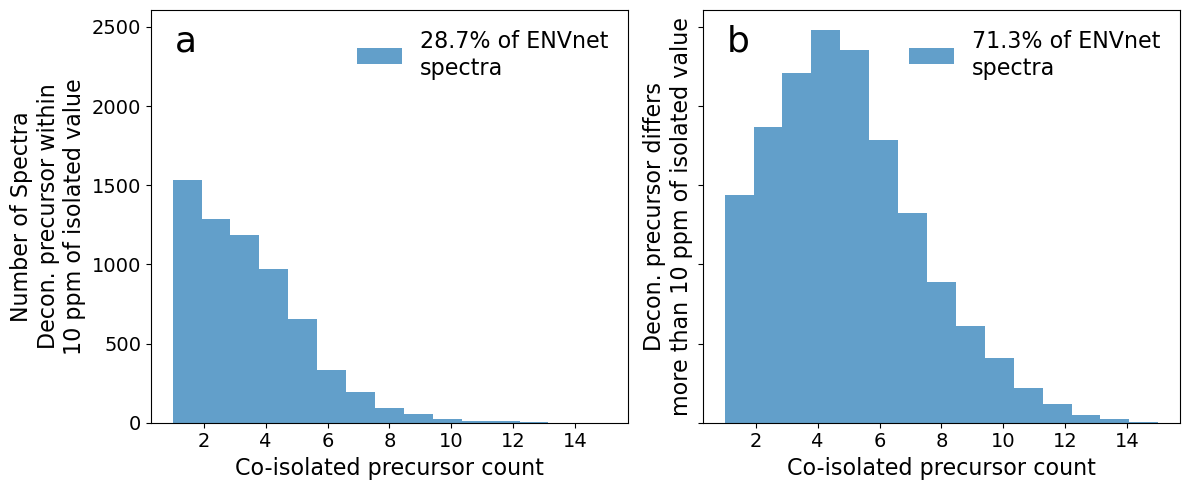

In [87]:
import os
PYTHONPATH = "/global/homes/b/bpb/repos/envnet"
if PYTHONPATH not in sys.path:
    sys.path.insert(0, PYTHONPATH)

from envnet.annotation.core import AnnotationEngine
annotation_engine = AnnotationEngine()
ref_dir = '/global/homes/b/bpb/repos/envnet/results/full_build_20250908_181404/'
node_data = annotation_engine.load_envnet_reference(
    graphml_file=os.path.join(ref_dir, "network_with_sirius.graphml"),
    mgf_base_name=os.path.join(ref_dir, "envnet")
)   
print(df.shape[0],sum(df['coisolated_precursor_count']>1))
cols = [  'precursor_mz', 'isolated_precursor_mz','coisolated_precursor_count',
       'filename', 'rt', 'num_datapoints', 'peak_area', 'peak_height', 'mz_centroid', 'rt_peak']
df = node_data['nodes'][cols].copy()
df['mz_error'] = abs(df['precursor_mz'] - df['isolated_precursor_mz']) / df['precursor_mz'] * 1e6

import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42  # TrueType fonts (searchable text)
matplotlib.rcParams['ps.fonttype'] = 42   # Also for PostScript output
# Use matplotlib's default font instead of specifying one that might not exist
matplotlib.rcParams['font.sans-serif'] = ['DejaVu Sans']#,'Geneva', 'DejaVu Sans', 'Liberation Sans', 'sans-serif']

fig,ax = plt.subplots(nrows=1,ncols=2,figsize=(12,5),sharex=True, sharey=True, tight_layout=True)
idx = df['mz_error'] < 10
ax[0].hist(df.loc[idx,'coisolated_precursor_count'], bins=(len(df['coisolated_precursor_count'].unique())),label=f'{sum(idx)/df.shape[0]:.1%} of ENVnet\nspectra', alpha=0.7)
idx = df['mz_error'] >= 10
ax[1].hist(df.loc[idx,'coisolated_precursor_count'], bins=(len(df['coisolated_precursor_count'].unique())),label=f'{sum(idx)/df.shape[0]:.1%} of ENVnet\nspectra', alpha=0.7)
# legend no box
ax[0].legend(frameon=False, fontsize=16)
ax[0].set_xlabel('Co-isolated precursor count', fontsize=16)
ax[0].set_ylabel('Number of Spectra\nDecon. precursor within\n10 ppm of isolated value', fontsize=16)
ax[1].set_ylabel('Decon. precursor differs\nmore than 10 ppm of isolated value', fontsize=16)
ax[1].set_xlabel('Co-isolated precursor count', fontsize=16)
ax[1].legend(frameon=False, fontsize=16)
# add a,b labels
ax[0].text(0.05, 0.9, 'a', transform=ax[0].transAxes, fontsize=26)
ax[1].text(0.05, 0.9, 'b', transform=ax[1].transAxes, fontsize=26)

# increase font size of ticks
ax[0].tick_params(axis='both', which='major', labelsize=14)
ax[1].tick_params(axis='both', which='major', labelsize=14)
fig.savefig('../validation_results/envnet_deconvolution_coisolation_stats.pdf')